# Cowell Propagation

This example demonstrates thecapabilities of AstroDynX's numerical orbital propagation using Cowell's method. The example compares different integration approaches and showcases JAX's automatic differentiation for computing state transition matrices.

## Key Features Demonstrated

**Numerical Integration**
- Cowell's method for orbital propagation
- Event detection during integration
- J2 perturbation effects

**JAX Capabilities**
- Automatic differentiation for state transition matrices
- JIT compilation for performance optimization
- Vectorized operations for batch processing

## Setup and Configuration

First, we import the necessary libraries and configure JAX for high precision computation. We also check the available devices for potential GPU acceleration.

In [1]:
%load_ext autoreload
%autoreload 2 

from jax import numpy as jnp
import jax
from astrodynx import diffeq
import astrodynx as adx
from astrodynx import prop
from matplotlib import pyplot as plt

jax.config.update("jax_enable_x64", True)
jax.devices()

[CudaDevice(id=0), CudaDevice(id=1)]

## Cowell's Method for Orbital Propagation
### Orbital Dynamics
The above example demonstrates Cowell's method for orbital propagation with the following key features:

- **Force Models**: We combine point mass gravity with J2 perturbations
- **Event Detection**: The integration automatically stops when the satellite altitude drops below a minimum radius




**Cowell's Method**

Direct numerical integration of the equations of motion:

$$\frac{d^2\mathbf{r}}{dt^2} = -\frac{\mu}{r^3}\mathbf{r} + \mathbf{a}_{pert}$$

**J2~J4 Perturbation**

Earth's oblateness effect:

$$\mathbf{a}_{J2} = -\frac{3\mu J_2 R_E^2}{2r^5}\begin{bmatrix}
x(1 - 5 \frac{z^2}{r^2}) \\
y(1 - 5 \frac{z^2}{r^2}) \\
z(3 - 5 \frac{z^2}{r^2})
\end{bmatrix}$$

$$\mathbf{a}_{J3} = -\frac{5\mu J_3 R_E^3}{2r^7}\begin{bmatrix}
x(3 z - \frac{7 z^3}{r^2}) \\
y(3 z - \frac{7 z^3}{r^2}) \\
6 z^2 - \frac{7 z^4}{r^2} - \frac{3}{5} r^2
\end{bmatrix}$$

$$\mathbf{a}_{J4} = \frac{15\mu J_4 R_E^4}{8r^7}\begin{bmatrix}
x(1 - \frac{14 z^2}{r^2} + \frac{21 z^4}{r^4}) \\
y(1 - \frac{14 z^2}{r^2} + \frac{21 z^4}{r^4}) \\
z(5 - \frac{70 z^2}{3 r^2} + \frac{21 z^4}{r^4})
\end{bmatrix}$$



**Event Detection**

The integration stops when the satellite falls below the minimum radius.
$$r < r_{min}$$


In [2]:
def vector_field(t, x, args):
    acc = adx.gravity.point_mass_grav(t, x, args)
    acc += adx.gravity.j2_acc(t, x, args)
    acc += adx.gravity.j3_acc(t, x, args)
    acc += adx.gravity.j4_acc(t, x, args)
    return jnp.concatenate([x[3:], acc])


args = {"mu": 1.0, "rmin": 0.7, "J2": 1e-6, "J3": 1e-8, "J4": 1e-9, "R_eq": 1.0}

orbdyn = adx.prop.OrbDynx(
    terms=diffeq.ODETerm(vector_field),
    args=args,
    event=diffeq.Event(adx.events.radius_islow),
)

x0 = jnp.array([1.0, 0.0, 0.0, 0.0, 0.9, 0.0])

### Propagate with Adaptive Steps
The solver uses adaptive time stepping for optimal accuracy and efficiency

solution steps: 4097
ts shape: (26,)


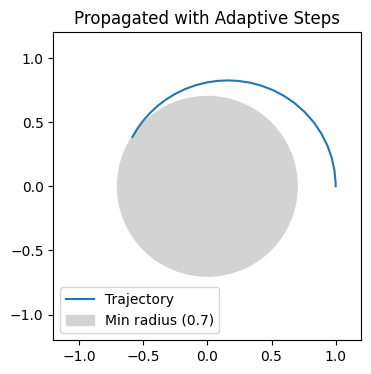

In [3]:
t1 = 3.1

sol = prop.adaptive_steps(orbdyn, x0, t1)

ts = jax.device_get(sol.ts[jnp.isfinite(sol.ts)])
print(f"solution steps: {sol.ts.size}")
print(f"ts shape: {ts.shape}")

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol.ys[:, 0], sol.ys[:, 1], label="Trajectory")
circle = plt.Circle(
    (0, 0), radius=args["rmin"], color="lightgray", label=f"Min radius ({args['rmin']})"
)
ax.add_patch(circle)
ax.set_aspect("equal")
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.legend()
ax.set_title("Propagated with Adaptive Steps")
plt.show()

The trajectory shows the satellite's path in the x-y plane, with the gray circle representing the minimum allowed altitude. The integration terminates when the satellite would impact this boundary.

### Propagate with Fixed Steps

solution steps: 4097
ts shape: (23,)
step length: 0.10000000000000003


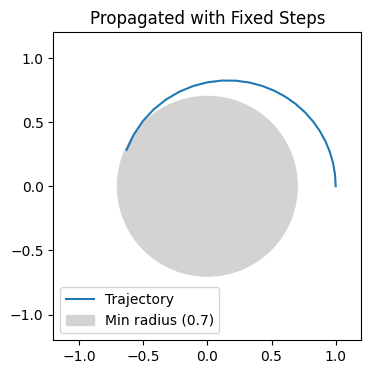

In [4]:
dt = 0.1
sol = prop.fixed_steps(orbdyn, x0, t1, dt)
print(f"solution steps: {sol.ts.size}")
ts = jax.device_get(sol.ts[jnp.isfinite(sol.ts)])
print(f"ts shape: {ts.shape}")
step = jnp.mean(ts[1:] - ts[:-1])
print(f"step length: {step}")

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol.ys[:, 0], sol.ys[:, 1], label="Trajectory")
circle = plt.Circle(
    (0, 0), radius=args["rmin"], color="lightgray", label=f"Min radius ({args['rmin']})"
)
ax.add_patch(circle)
ax.set_aspect("equal")
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.legend()
ax.set_title("Propagated with Fixed Steps")
plt.show()

### Propagate with Custom Steps

solution steps: 32
ts shape: (22,)


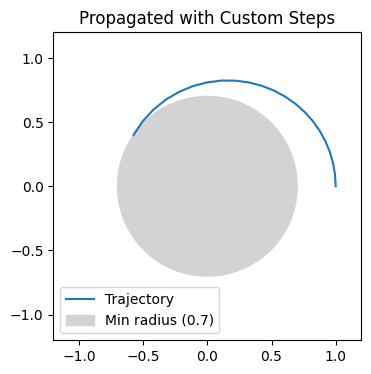

In [5]:
timesteps = jnp.linspace(0, t1, 32)
sol = prop.custom_steps(orbdyn, x0, t1, timesteps)
print(f"solution steps: {sol.ts.size}")
ts = jax.device_get(sol.ts[jnp.isfinite(sol.ts)])
print(f"ts shape: {ts.shape}")

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol.ys[:, 0], sol.ys[:, 1], label="Trajectory")
circle = plt.Circle(
    (0, 0), radius=args["rmin"], color="lightgray", label=f"Min radius ({args['rmin']})"
)
ax.add_patch(circle)
ax.set_aspect("equal")
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.legend()
ax.set_title("Propagated with Custom Steps")
plt.show()

### Propagate to Final Step

In [6]:
sol = prop.to_final(orbdyn, x0, t1)
print(f"final time: {sol.ts}")
print(f"final state: {sol.ys}")

final time: [2.11521861]
final state: [[-5.84077092e-01  3.84040133e-01  3.14508631e-08 -6.10440122e-01
  -1.13951823e+00  2.55610576e-08]]


## State Transition Matrix Computation

The above example demonstrates a powerful capability of JAX: computing exact derivatives through automatic differentiation. Here's what happened:

1. **Automatic Jacobian**: `jax.jacrev(yf)(x0)` computes the Jacobian matrix $\frac{\partial \mathbf{x}(t)}{\partial \mathbf{x}_0}$ automatically
2. **Analytical Comparison**: We compare against the analytical two-body solution to verify accuracy
3. **High Precision**: The results match to machine precision (1e-7 tolerance)

**State Transition Matrix**

The linearized dynamics around a reference trajectory:

$$\Phi(t, t_0) = \frac{\partial \mathbf{x}(t)}{\partial \mathbf{x}_0}$$

In [7]:
deltat = 2.5803148345055149
mu = 1.0

# initial state
r0_vec = jnp.array([-0.66234662571997105, 0.74919751798749190, -1.6259997018919074e-4])
v0_vec = jnp.array([-0.8166746784630675, -0.32961417380268476, 0.006248107587795581])

# final state
r_vec = jnp.array([-0.24986234273434585, -0.69332384278075210, 4.9599012168662551e-3])
v_vec = jnp.array([1.2189179487500401, 0.05977450696618754, -0.007101943980682161])

### Verify the finnal state

In [8]:
def vector_field(t, x, args):
    acc = adx.gravity.point_mass_grav(t, x, args)
    return jnp.concatenate([x[3:], acc])


args = {"mu": mu}

orbdyn = adx.prop.OrbDynx(
    terms=diffeq.ODETerm(vector_field),
    args=args,
)

x0 = jnp.concatenate([r0_vec, v0_vec])
x1 = jnp.concatenate([r_vec, v_vec])
sol = prop.to_final(orbdyn, x0, deltat)
assert jnp.allclose(sol.ys[-1], x1, atol=1e-7)
r, v = prop.kepler(deltat, r0_vec, v0_vec, mu)
assert jnp.allclose(sol.ys[-1, :3], r[-1], atol=1e-7)
assert jnp.allclose(sol.ys[-1, 3:], v[-1], atol=1e-5)

### Compute the State Transition Matrix

In [9]:
def yf(x, orbdyn, t1):
    return prop.to_final(orbdyn, x, t1).ys[-1]


jac_auto = jax.jacrev(yf)(x0, orbdyn, deltat)

jac_analytic = adx.twobody.dxdx0(r_vec, v_vec, r0_vec, v0_vec, deltat)
assert jnp.allclose(jac_auto, jac_analytic, atol=1e-7)